# Data Frame Form Directory of MultipleFiles

### Set up the Environment

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import clear_output
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
clear_output()

In [4]:
!pip install pyspark
clear_output()

### Import Spark and other classes

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,FloatType

### Download the Dataset -- > A Zip file

In [6]:
!gdown 1GriHiFQj0lwyRPXZKZyNKLnDrQBCoL27

Downloading...
From: https://drive.google.com/uc?id=1GriHiFQj0lwyRPXZKZyNKLnDrQBCoL27
To: /content/salesdata.zip
100% 2.33M/2.33M [00:00<00:00, 196MB/s]


In [7]:
import os
[x for x in os.listdir() if x.endswith('.zip')]

['salesdata.zip']

In [8]:
from helper_functions import unzip_untar_data

In [9]:
unzip_untar_data('salesdata.zip')

File extension: .zip
File extracting.......

Extraction Completed successfully
Deleted source file


### Crate the Spark Application Instance

In [10]:
spark = SparkSession.builder.appName('readMutipleFilesFromDirectory').getOrCreate()

### Create Schema for the dataFrame

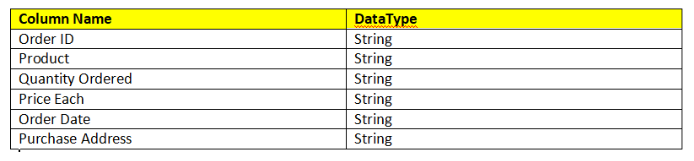

In [11]:
schema = StructType([
    StructField('Order Id', StringType(), True),
    StructField('Product', StringType(), True),
    StructField('Quantity Ordered', IntegerType(), True),
    StructField('Price Each', FloatType(), True),
    StructField('Order Date', StringType(), True),
    StructField('Purchase Address', StringType(), True)
])

### Define an Directory where the multiple files are contained

In [12]:
files_directory = '/content/salesdata' # pointing to the folder of mutiple csv file of same format

### Read all the files from the directory

In [13]:
read_format = spark.read.format('csv')
read_format = read_format.option('header',True)
read_format = read_format.schema(schema)

sales_dataframe = read_format.load(files_directory)

The Difference is if there are multiple files need to be read, then just point to the directory otherwise just point to the file

In [14]:
sales_dataframe.columns

['Order Id',
 'Product',
 'Quantity Ordered',
 'Price Each',
 'Order Date',
 'Purchase Address']

In [15]:
sales_dataframe.printSchema()

root
 |-- Order Id: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: float (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



In [16]:
sales_dataframe.show(10, truncate = False)

+--------+--------------------------+----------------+----------+--------------+-----------------------------------------+
|Order Id|Product                   |Quantity Ordered|Price Each|Order Date    |Purchase Address                         |
+--------+--------------------------+----------------+----------+--------------+-----------------------------------------+
|295665  |Macbook Pro Laptop        |1               |1700.0    |12/30/19 00:01|136 Church St, New York City, NY 10001   |
|295666  |LG Washing Machine        |1               |600.0     |12/29/19 07:03|562 2nd St, New York City, NY 10001      |
|295667  |USB-C Charging Cable      |1               |11.95     |12/12/19 18:21|277 Main St, New York City, NY 10001     |
|295668  |27in FHD Monitor          |1               |149.99    |12/22/19 15:13|410 6th St, San Francisco, CA 94016      |
|295669  |USB-C Charging Cable      |1               |11.95     |12/18/19 12:38|43 Hill St, Atlanta, GA 30301            |
|295670  |AA Bat

In [17]:
sales_dataframe.count()

186850

### Describe the DataFrame

In [18]:
sales_dataframe.describe().show()

+-------+-----------------+------------+-------------------+-----------------+--------------+--------------------+
|summary|         Order Id|     Product|   Quantity Ordered|       Price Each|    Order Date|    Purchase Address|
+-------+-----------------+------------+-------------------+-----------------+--------------+--------------------+
|  count|           186305|      186305|             185950|           185950|        186305|              186305|
|   mean|230417.5693788653|        null| 1.1243828986286637|184.3997338440329|          null|                null|
| stddev|51512.73710999602|        null|0.44279262402866804|332.7313290259732|          null|                null|
|    min|           141234|20in Monitor|                  1|             2.99|01/01/19 03:07|1 11th St, Atlant...|
|    max|         Order ID|      iPhone|                  9|           1700.0|    Order Date|    Purchase Address|
+-------+-----------------+------------+-------------------+-----------------+--

In [19]:
sales_dataframe.count()

186850

### Lets check the null values

In [20]:
from pyspark.sql.functions import col

In [21]:
null_count = {x:sales_dataframe.where(col(x).isNull()).count() for x in sales_dataframe.columns}
null_count

{'Order Id': 545,
 'Product': 545,
 'Quantity Ordered': 900,
 'Price Each': 900,
 'Order Date': 545,
 'Purchase Address': 545}

### Remove all the records with null values

In [22]:
sales_dataframe = sales_dataframe.na.drop('any')

In [23]:
null_count = {x:sales_dataframe.where(col(x).isNull()).count() for x in sales_dataframe.columns}
null_count

{'Order Id': 0,
 'Product': 0,
 'Quantity Ordered': 0,
 'Price Each': 0,
 'Order Date': 0,
 'Purchase Address': 0}

In [24]:
sales_dataframe.count()

185950

### Drop Duplicated records

In [25]:
sales_dataframe = sales_dataframe.dropDuplicates()

In [26]:
sales_dataframe.count()

185686

### Recheck the dataframe

In [27]:
sales_dataframe.describe().show()

+-------+------------------+------------+------------------+------------------+--------------+--------------------+
|summary|          Order Id|     Product|  Quantity Ordered|        Price Each|    Order Date|    Purchase Address|
+-------+------------------+------------+------------------+------------------+--------------+--------------------+
|  count|            185686|      185686|            185686|            185686|        185686|              185686|
|   mean|230411.37622653297|        null|1.1245435843305365| 184.5192545397916|          null|                null|
| stddev| 51511.71718332079|        null|0.4430687383832881|332.84383753158903|          null|                null|
|    min|            141234|20in Monitor|                 1|              2.99|01/01/19 03:07|1 11th St, Atlant...|
|    max|            319670|      iPhone|                 9|            1700.0|12/31/19 23:53|999 Wilson St, Sa...|
+-------+------------------+------------+------------------+------------

### Check for the records with values == column Name

In [28]:
wrong_values = {x:sales_dataframe.where(col(x) == x).count() for x in sales_dataframe.columns}
wrong_values

{'Order Id': 0,
 'Product': 0,
 'Quantity Ordered': 0,
 'Price Each': 0,
 'Order Date': 0,
 'Purchase Address': 0}

### Get the City and State values from the Address

In [29]:
sales_dataframe.select('Purchase Address').show(10, truncate = False)

+---------------------------------------+
|Purchase Address                       |
+---------------------------------------+
|368 Sunset St, New York City, NY 10001 |
|863 West St, San Francisco, CA 94016   |
|311 Spruce St, Boston, MA 02215        |
|74 1st St, New York City, NY 10001     |
|168 10th St, Portland, ME 04101        |
|910 Hickory St, New York City, NY 10001|
|238 Adams St, San Francisco, CA 94016  |
|594 North St, Los Angeles, CA 90001    |
|514 Hickory St, Dallas, TX 75001       |
|542 Center St, San Francisco, CA 94016 |
+---------------------------------------+
only showing top 10 rows



Second item in the address is `City`
Third item in the address is `State`

In [30]:
from pyspark.sql.functions import split

In [31]:
sales_dataframe.select(split(col('Purchase Address'),',')).show(10, truncate = False)

+-------------------------------------------+
|split(Purchase Address, ,, -1)             |
+-------------------------------------------+
|[368 Sunset St,  New York City,  NY 10001] |
|[863 West St,  San Francisco,  CA 94016]   |
|[311 Spruce St,  Boston,  MA 02215]        |
|[74 1st St,  New York City,  NY 10001]     |
|[168 10th St,  Portland,  ME 04101]        |
|[910 Hickory St,  New York City,  NY 10001]|
|[238 Adams St,  San Francisco,  CA 94016]  |
|[594 North St,  Los Angeles,  CA 90001]    |
|[514 Hickory St,  Dallas,  TX 75001]       |
|[542 Center St,  San Francisco,  CA 94016] |
+-------------------------------------------+
only showing top 10 rows



In [32]:
city = sales_dataframe.select(split(col('Purchase Address'),',').getItem(1).alias('city'))
city.show(10,False)

+--------------+
|city          |
+--------------+
| New York City|
| San Francisco|
| Boston       |
| New York City|
| Portland     |
| New York City|
| San Francisco|
| Los Angeles  |
| Dallas       |
| San Francisco|
+--------------+
only showing top 10 rows



In [33]:
state = sales_dataframe.select(split(split(col('Purchase Address'), ',').getItem(2), " ").getItem(1).alias('state'))
state.show(10,False)

+-----+
|state|
+-----+
|NY   |
|CA   |
|MA   |
|NY   |
|ME   |
|NY   |
|CA   |
|CA   |
|TX   |
|CA   |
+-----+
only showing top 10 rows



In [34]:
city_expression = split(col('Purchase Address'),',').getItem(1)
state_expression = split(split(col('Purchase Address'), ',').getItem(2), " ").getItem(1)


sales_dataframe = sales_dataframe.withColumn('city',city_expression).withColumn('state',state_expression)
sales_dataframe.show(10,truncate = False)

+--------+--------------------------+----------------+----------+--------------+---------------------------------------+--------------+-----+
|Order Id|Product                   |Quantity Ordered|Price Each|Order Date    |Purchase Address                       |city          |state|
+--------+--------------------------+----------------+----------+--------------+---------------------------------------+--------------+-----+
|295742  |Apple Airpods Headphones  |1               |150.0     |12/09/19 23:45|368 Sunset St, New York City, NY 10001 | New York City|NY   |
|295948  |Macbook Pro Laptop        |1               |1700.0    |12/17/19 21:08|863 West St, San Francisco, CA 94016   | San Francisco|CA   |
|296010  |27in 4K Gaming Monitor    |1               |389.99    |12/13/19 13:00|311 Spruce St, Boston, MA 02215        | Boston       |MA   |
|296044  |AA Batteries (4-pack)     |3               |3.84      |12/26/19 16:50|74 1st St, New York City, NY 10001     | New York City|NY   |
|29635

### Type Casting of Columns

In [35]:
sales_dataframe.printSchema()

root
 |-- Order Id: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: float (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



In [36]:
from pyspark.sql.types import IntegerType,FloatType,DateType
from pyspark.sql.functions import to_timestamp

In [37]:
# convert order id into integer
sales_dataframe = sales_dataframe.withColumn('OrderID', col('Order Id').cast(IntegerType())).drop(col('Order Id'))
sales_dataframe.show(5,False)

+------------------------+----------------+----------+--------------+--------------------------------------+--------------+-----+-------+
|Product                 |Quantity Ordered|Price Each|Order Date    |Purchase Address                      |city          |state|OrderID|
+------------------------+----------------+----------+--------------+--------------------------------------+--------------+-----+-------+
|Apple Airpods Headphones|1               |150.0     |12/09/19 23:45|368 Sunset St, New York City, NY 10001| New York City|NY   |295742 |
|Macbook Pro Laptop      |1               |1700.0    |12/17/19 21:08|863 West St, San Francisco, CA 94016  | San Francisco|CA   |295948 |
|27in 4K Gaming Monitor  |1               |389.99    |12/13/19 13:00|311 Spruce St, Boston, MA 02215       | Boston       |MA   |296010 |
|AA Batteries (4-pack)   |3               |3.84      |12/26/19 16:50|74 1st St, New York City, NY 10001    | New York City|NY   |296044 |
|ThinkPad Laptop         |1       

In [38]:
# convert the order date into timestamp

sales_dataframe = sales_dataframe.withColumn('Timestamp', to_timestamp(col('Order Date'), "MM/dd/yy HH:mm")).drop(col('Order Date'))
sales_dataframe.show(5,False)

+------------------------+----------------+----------+--------------------------------------+--------------+-----+-------+-------------------+
|Product                 |Quantity Ordered|Price Each|Purchase Address                      |city          |state|OrderID|Timestamp          |
+------------------------+----------------+----------+--------------------------------------+--------------+-----+-------+-------------------+
|Apple Airpods Headphones|1               |150.0     |368 Sunset St, New York City, NY 10001| New York City|NY   |295742 |2019-12-09 23:45:00|
|Macbook Pro Laptop      |1               |1700.0    |863 West St, San Francisco, CA 94016  | San Francisco|CA   |295948 |2019-12-17 21:08:00|
|27in 4K Gaming Monitor  |1               |389.99    |311 Spruce St, Boston, MA 02215       | Boston       |MA   |296010 |2019-12-13 13:00:00|
|AA Batteries (4-pack)   |3               |3.84      |74 1st St, New York City, NY 10001    | New York City|NY   |296044 |2019-12-26 16:50:00|

In [39]:
sales_dataframe.printSchema()

root
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: float (nullable = true)
 |-- Purchase Address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- OrderID: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)



### Get `Month` & `Year` information from the time stamp

In [40]:
from pyspark.sql.functions import month,year

In [41]:
sales_dataframe = sales_dataframe.withColumn('sales_month', month(col('Timestamp'))).withColumn('sales_year',year(col('Timestamp')))
sales_dataframe.show(5,False)

+------------------------+----------------+----------+--------------------------------------+--------------+-----+-------+-------------------+-----------+----------+
|Product                 |Quantity Ordered|Price Each|Purchase Address                      |city          |state|OrderID|Timestamp          |sales_month|sales_year|
+------------------------+----------------+----------+--------------------------------------+--------------+-----+-------+-------------------+-----------+----------+
|Apple Airpods Headphones|1               |150.0     |368 Sunset St, New York City, NY 10001| New York City|NY   |295742 |2019-12-09 23:45:00|12         |2019      |
|Macbook Pro Laptop      |1               |1700.0    |863 West St, San Francisco, CA 94016  | San Francisco|CA   |295948 |2019-12-17 21:08:00|12         |2019      |
|27in 4K Gaming Monitor  |1               |389.99    |311 Spruce St, Boston, MA 02215       | Boston       |MA   |296010 |2019-12-13 13:00:00|12         |2019      |
|AA 

### `withColumnRenamed` to rename a column

In [42]:
sales_dataframe = sales_dataframe.withColumnRenamed('Purchase Address','store_address')
sales_dataframe.show(5)

+--------------------+----------------+----------+--------------------+--------------+-----+-------+-------------------+-----------+----------+
|             Product|Quantity Ordered|Price Each|       store_address|          city|state|OrderID|          Timestamp|sales_month|sales_year|
+--------------------+----------------+----------+--------------------+--------------+-----+-------+-------------------+-----------+----------+
|Apple Airpods Hea...|               1|     150.0|368 Sunset St, Ne...| New York City|   NY| 295742|2019-12-09 23:45:00|         12|      2019|
|  Macbook Pro Laptop|               1|    1700.0|863 West St, San ...| San Francisco|   CA| 295948|2019-12-17 21:08:00|         12|      2019|
|27in 4K Gaming Mo...|               1|    389.99|311 Spruce St, Bo...|        Boston|   MA| 296010|2019-12-13 13:00:00|         12|      2019|
|AA Batteries (4-p...|               3|      3.84|74 1st St, New Yo...| New York City|   NY| 296044|2019-12-26 16:50:00|         12|    

In [43]:
sales_dataframe = sales_dataframe.withColumnRenamed('Quantity Ordered','quantity_ordered')
sales_dataframe.show(5)

+--------------------+----------------+----------+--------------------+--------------+-----+-------+-------------------+-----------+----------+
|             Product|quantity_ordered|Price Each|       store_address|          city|state|OrderID|          Timestamp|sales_month|sales_year|
+--------------------+----------------+----------+--------------------+--------------+-----+-------+-------------------+-----------+----------+
|Apple Airpods Hea...|               1|     150.0|368 Sunset St, Ne...| New York City|   NY| 295742|2019-12-09 23:45:00|         12|      2019|
|  Macbook Pro Laptop|               1|    1700.0|863 West St, San ...| San Francisco|   CA| 295948|2019-12-17 21:08:00|         12|      2019|
|27in 4K Gaming Mo...|               1|    389.99|311 Spruce St, Bo...|        Boston|   MA| 296010|2019-12-13 13:00:00|         12|      2019|
|AA Batteries (4-p...|               3|      3.84|74 1st St, New Yo...| New York City|   NY| 296044|2019-12-26 16:50:00|         12|    

In [44]:
sales_dataframe = sales_dataframe.withColumnRenamed('Price Each','price_each')
sales_dataframe.show(5)

+--------------------+----------------+----------+--------------------+--------------+-----+-------+-------------------+-----------+----------+
|             Product|quantity_ordered|price_each|       store_address|          city|state|OrderID|          Timestamp|sales_month|sales_year|
+--------------------+----------------+----------+--------------------+--------------+-----+-------+-------------------+-----------+----------+
|Apple Airpods Hea...|               1|     150.0|368 Sunset St, Ne...| New York City|   NY| 295742|2019-12-09 23:45:00|         12|      2019|
|  Macbook Pro Laptop|               1|    1700.0|863 West St, San ...| San Francisco|   CA| 295948|2019-12-17 21:08:00|         12|      2019|
|27in 4K Gaming Mo...|               1|    389.99|311 Spruce St, Bo...|        Boston|   MA| 296010|2019-12-13 13:00:00|         12|      2019|
|AA Batteries (4-p...|               3|      3.84|74 1st St, New Yo...| New York City|   NY| 296044|2019-12-26 16:50:00|         12|    

### Re-Order the columns in the dataframe

In [45]:
column_order = ('OrderID','Timestamp','sales_year','sales_month','store_address','city','state','Product','quantity_ordered','price_each')

In [46]:
sales_dataframe = sales_dataframe.select(*column_order)
sales_dataframe.show(10)

+-------+-------------------+----------+-----------+--------------------+--------------+-----+--------------------+----------------+----------+
|OrderID|          Timestamp|sales_year|sales_month|       store_address|          city|state|             Product|quantity_ordered|price_each|
+-------+-------------------+----------+-----------+--------------------+--------------+-----+--------------------+----------------+----------+
| 295742|2019-12-09 23:45:00|      2019|         12|368 Sunset St, Ne...| New York City|   NY|Apple Airpods Hea...|               1|     150.0|
| 295948|2019-12-17 21:08:00|      2019|         12|863 West St, San ...| San Francisco|   CA|  Macbook Pro Laptop|               1|    1700.0|
| 296010|2019-12-13 13:00:00|      2019|         12|311 Spruce St, Bo...|        Boston|   MA|27in 4K Gaming Mo...|               1|    389.99|
| 296044|2019-12-26 16:50:00|      2019|         12|74 1st St, New Yo...| New York City|   NY|AA Batteries (4-p...|               3|    

### Save the DataFrame to parquet format

In [47]:
!mkdir sales_output

In [48]:
destination = '/content/sales_output'

In [49]:
sales_dataframe.write.format('parquet').mode('overwrite').partitionBy('sales_year','sales_month').save(destination)

### Save the DataFrame to csv format

In [50]:
!mkdir sales_output_csv

In [51]:
destination_csv = '/content/sales_output_csv'

In [52]:
sales_dataframe.write.format('csv').mode('overwrite').partitionBy('sales_year','sales_month').save(destination_csv)

### Read The parquete data for year 2019

In [53]:
data_source = '/content/sales_output/'
partition = 'sales_year=2019'

path = f'{data_source}{partition}'
path

'/content/sales_output/sales_year=2019'

In [54]:
sales2019_dataframe = spark.read.parquet(path)

sales2019_dataframe.show(10,False)

+-------+-------------------+----------------------------------------+--------------+-----+--------------------------+----------------+----------+-----------+
|OrderID|Timestamp          |store_address                           |city          |state|Product                   |quantity_ordered|price_each|sales_month|
+-------+-------------------+----------------------------------------+--------------+-----+--------------------------+----------------+----------+-----------+
|295822 |2019-12-04 13:53:00|307 Wilson St, San Francisco, CA 94016  | San Francisco|CA   |Wired Headphones          |1               |11.99     |12         |
|296039 |2019-12-11 13:16:00|856 Madison St, Los Angeles, CA 90001   | Los Angeles  |CA   |Wired Headphones          |1               |11.99     |12         |
|296040 |2019-12-25 16:30:00|794 West St, Atlanta, GA 30301          | Atlanta      |GA   |27in FHD Monitor          |1               |149.99    |12         |
|296226 |2019-12-27 22:39:00|891 Hill St, San 

Lets calculate the revenue against each transactions

In [55]:
from pyspark.sql.functions import expr

In [56]:
sales2019_dataframe = sales2019_dataframe.withColumn('revenue',expr('quantity_ordered * price_each'))

sales2019_dataframe.show(5)

+-------+-------------------+--------------------+--------------+-----+--------------------+----------------+----------+-----------+-------+
|OrderID|          Timestamp|       store_address|          city|state|             Product|quantity_ordered|price_each|sales_month|revenue|
+-------+-------------------+--------------------+--------------+-----+--------------------+----------------+----------+-----------+-------+
| 295822|2019-12-04 13:53:00|307 Wilson St, Sa...| San Francisco|   CA|    Wired Headphones|               1|     11.99|         12|  11.99|
| 296039|2019-12-11 13:16:00|856 Madison St, L...|   Los Angeles|   CA|    Wired Headphones|               1|     11.99|         12|  11.99|
| 296040|2019-12-25 16:30:00|794 West St, Atla...|       Atlanta|   GA|    27in FHD Monitor|               1|    149.99|         12| 149.99|
| 296226|2019-12-27 22:39:00|891 Hill St, San ...| San Francisco|   CA|Apple Airpods Hea...|               1|     150.0|         12|  150.0|
| 296405|2019

In [57]:
sales2019_dataframe.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- store_address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- quantity_ordered: integer (nullable = true)
 |-- price_each: float (nullable = true)
 |-- sales_month: integer (nullable = true)
 |-- revenue: float (nullable = true)



which was the best month for sales in 2019 ?

In [58]:
from pyspark.sql.functions import asc,desc
from pyspark.sql.functions import sum,round

**Very Important , The functons like sum, round etc has to be imported from pyspark to get it worked, the python-buildt in sum,round functions will fail in pyspark operations**

In [59]:
sales2019_gr_months = sales2019_dataframe.groupBy('sales_month') \
                              .agg(round(sum(col('revenue')),2).alias('total_revenue')) \
                              .orderBy(desc('total_revenue'))

sales2019_gr_months.show()

+-----------+-------------+
|sales_month|total_revenue|
+-----------+-------------+
|         12|   4608295.68|
|         10|   3734777.84|
|          4|   3389217.96|
|         11|   3197875.03|
|          5|   3150616.21|
|          3|   2804973.34|
|          7|   2646461.31|
|          6|   2576280.14|
|          8|   2241083.36|
|          2|   2200078.07|
|          9|   2094465.68|
|          1|   1812742.86|
+-----------+-------------+



**In order to vsizualize the aggregated data, the pyspark dataframe need to be converted into pandas dataframe using `to_pandas method` then use the visualization libraries like matplotlib and seaborn**

### A Note on Spark Vs Pandas

Pyspark and Pandas are both popular data manipulation and analysis libraries, but they differ in their underlying architectures and use cases.

Pyspark, based on Apache Spark, is designed for big data processing and distributed computing. It offers scalability, fault tolerance, and efficient processing on large datasets across clusters. Pyspark utilizes a distributed computing framework, allowing it to handle massive volumes of data with built-in parallel processing capabilities.

On the other hand, Pandas is a Python library designed for smaller datasets that can fit into memory. It provides a high-performance, easy-to-use data manipulation and analysis interface, suitable for exploratory data analysis, data cleaning, and modeling tasks. Pandas offers a wide range of functions and operations optimized for in-memory data processing.

In summary, Pyspark is ideal for big data processing in distributed environments, while Pandas is well-suited for smaller datasets and interactive data analysis in memory-constrained environments.

### Converting the Spark Data Frame to Pandas DataFrame

In [60]:
sales2019_gr_months_pandas = sales2019_gr_months.toPandas()
sales2019_gr_months_pandas

,sales_month,total_revenue
0,12,4608295.68
1,10,3734777.84
2,4,3389217.96
3,11,3197875.03
4,5,3150616.21
5,3,2804973.34
6,7,2646461.31
7,6,2576280.14
8,8,2241083.36
9,2,2200078.07


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

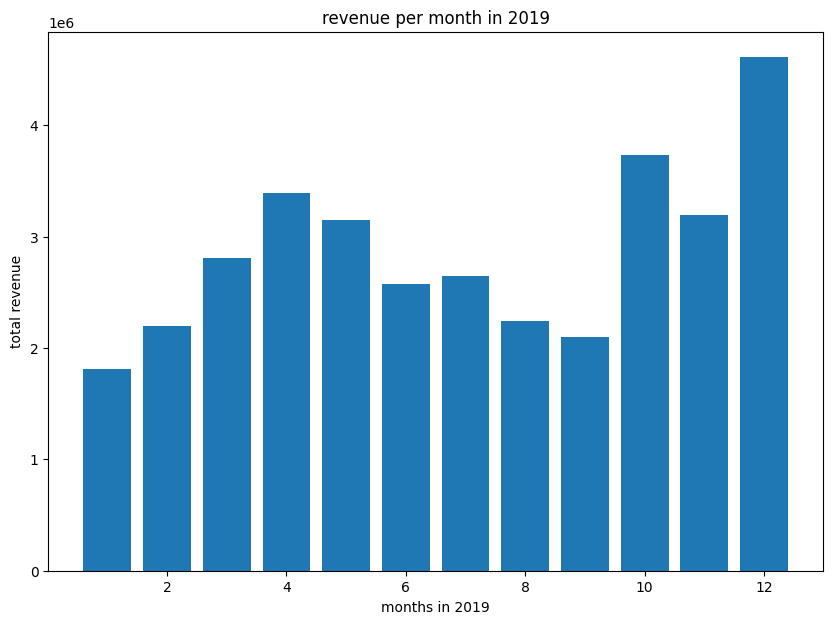

In [62]:
plt.figure(figsize = (10,7))
plt.bar(x = 'sales_month', height = 'total_revenue', data = sales2019_gr_months_pandas)
plt.xlabel('months in 2019')
plt.ylabel('total revenue')
plt.title('revenue per month in 2019')
plt.show()

Which city sold the most products ?

In [63]:
sales2019_gr_city = sales2019_dataframe.groupBy('city')\
                                        .agg(sum('quantity_ordered').alias('number_of_products'))\
                                        .orderBy(desc('number_of_products'))
sales2019_gr_city.show()

+--------------+------------------+
|          city|number_of_products|
+--------------+------------------+
| San Francisco|             50156|
|   Los Angeles|             33246|
| New York City|             27887|
|        Boston|             22490|
|        Dallas|             16705|
|       Atlanta|             16584|
|       Seattle|             16533|
|      Portland|             14035|
|        Austin|             11135|
+--------------+------------------+



In [64]:
sales2019_gr_city_pandas = sales2019_gr_city.toPandas()
sales2019_gr_city_pandas

,city,number_of_products
0,San Francisco,50156
1,Los Angeles,33246
2,New York City,27887
3,Boston,22490
4,Dallas,16705
5,Atlanta,16584
6,Seattle,16533
7,Portland,14035
8,Austin,11135


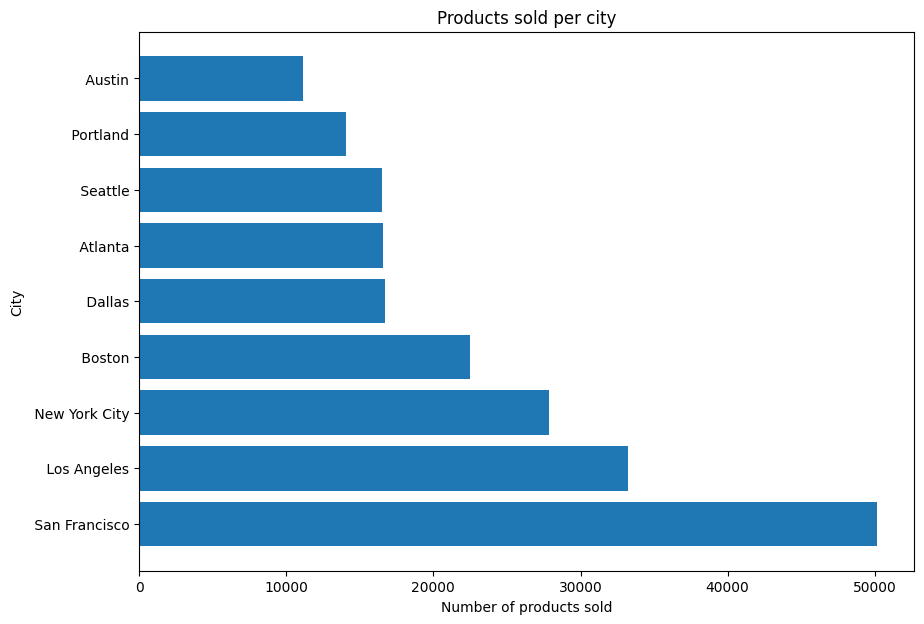

In [65]:
plt.figure(figsize=(10, 7))
plt.barh(y='city', width='number_of_products', data=sales2019_gr_city_pandas)
plt.xlabel('Number of products sold')
plt.ylabel('City')
plt.title('Products sold per city')
plt.show()

At what time we should display our advertisement that maximize the likelyhood of customers buying products ?

In essence you want to calculate the number of orders being made by hours

In [67]:
sales2019_dataframe.columns

['OrderID',
 'Timestamp',
 'store_address',
 'city',
 'state',
 'Product',
 'quantity_ordered',
 'price_each',
 'sales_month',
 'revenue']

In [72]:
from pyspark.sql.functions import date_format

In [78]:
orders_hours_dataframe = sales2019_dataframe.select('OrderID',date_format('Timestamp','HH')\
                                            .cast(IntegerType()).alias('Hour'))\
                                            .distinct()
orders_hours_dataframe.show(10)

+-------+----+
|OrderID|Hour|
+-------+----+
| 304554|  20|
| 312763|  16|
| 304477|  17|
| 313497|  18|
| 309197|  20|
| 309648|   0|
| 318375|  20|
| 302620|  19|
| 304109|   9|
| 306067|  19|
+-------+----+
only showing top 10 rows



In [84]:
from pyspark.sql.functions import count

In [91]:
orders_by_hour = orders_hours_dataframe.groupBy('Hour') \
                                      .agg(count('OrderID').alias('count_orders')) \
                                      .orderBy(desc('count_orders'))

orders_by_hour.show()

+----+------------+
|Hour|count_orders|
+----+------------+
|  19|       12377|
|  12|       12082|
|  11|       11882|
|  20|       11763|
|  18|       11761|
|  13|       11682|
|  14|       10522|
|  21|       10499|
|  10|       10492|
|  17|       10476|
|  16|        9960|
|  15|        9761|
|  22|        8453|
|   9|        8404|
|   8|        6036|
|  23|        5990|
|   7|        3836|
|   0|        3748|
|   6|        2375|
|   1|        2246|
+----+------------+
only showing top 20 rows



In [92]:
orders_by_hour_pandas = orders_by_hour.toPandas()

In [100]:
import seaborn as sns

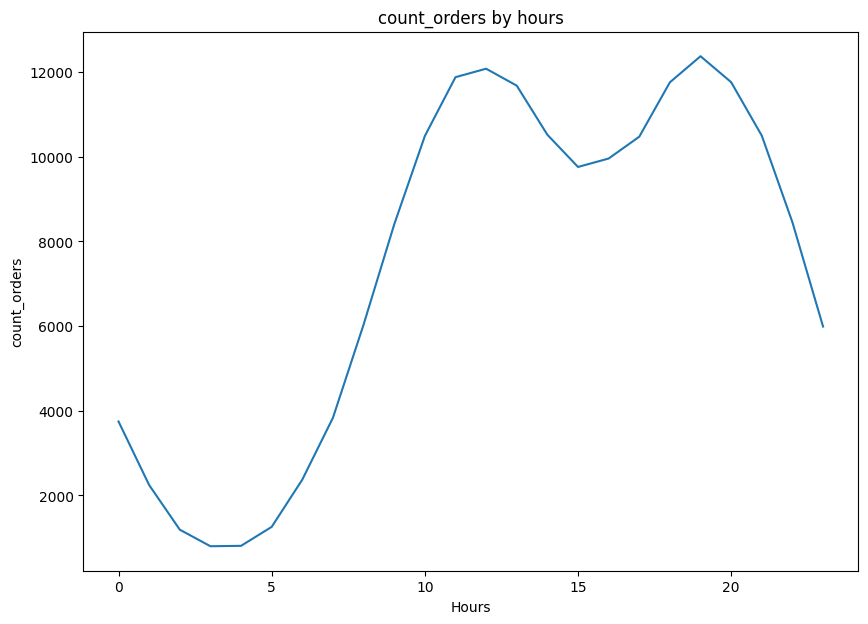

In [104]:
plt.figure(figsize=(10, 7))
sns.lineplot(x='Hour', y='count_orders',data = orders_by_hour_pandas)
plt.xlabel('Hours')
plt.ylabel('count_orders')
plt.title('count_orders by hours')
plt.show()

What products are aften sold together in the State of New Your ?

In [106]:
sales2019_dataframe.show(5)

+-------+-------------------+--------------------+--------------+-----+--------------------+----------------+----------+-----------+-------+
|OrderID|          Timestamp|       store_address|          city|state|             Product|quantity_ordered|price_each|sales_month|revenue|
+-------+-------------------+--------------------+--------------+-----+--------------------+----------------+----------+-----------+-------+
| 295822|2019-12-04 13:53:00|307 Wilson St, Sa...| San Francisco|   CA|    Wired Headphones|               1|     11.99|         12|  11.99|
| 296039|2019-12-11 13:16:00|856 Madison St, L...|   Los Angeles|   CA|    Wired Headphones|               1|     11.99|         12|  11.99|
| 296040|2019-12-25 16:30:00|794 West St, Atla...|       Atlanta|   GA|    27in FHD Monitor|               1|    149.99|         12| 149.99|
| 296226|2019-12-27 22:39:00|891 Hill St, San ...| San Francisco|   CA|Apple Airpods Hea...|               1|     150.0|         12|  150.0|
| 296405|2019

Lets get the data realted to NY

In [110]:
sales_2019_NY = sales2019_dataframe.where(col('state') == 'NY')
sales_2019_NY.show(10)

+-------+-------------------+--------------------+--------------+-----+--------------------+----------------+----------+-----------+-------+
|OrderID|          Timestamp|       store_address|          city|state|             Product|quantity_ordered|price_each|sales_month|revenue|
+-------+-------------------+--------------------+--------------+-----+--------------------+----------------+----------+-----------+-------+
| 299572|2019-12-30 09:17:00|757 Walnut St, Ne...| New York City|   NY|Apple Airpods Hea...|               1|     150.0|         12|  150.0|
| 299805|2019-12-09 08:47:00|37 Spruce St, New...| New York City|   NY|Lightning Chargin...|               1|     14.95|         12|  14.95|
| 300164|2019-12-17 19:41:00|950 Ridge St, New...| New York City|   NY|            LG Dryer|               1|     600.0|         12|  600.0|
| 300693|2019-12-22 15:02:00|183 Willow St, Ne...| New York City|   NY|Bose SoundSport H...|               1|     99.99|         12|  99.99|
| 300809|2019

### lets `aggregate the list` of products using `collect_list` for each order id

In [122]:
from pyspark.sql.functions import collect_list, sort_array

In [120]:
# groping by Order ID - count of products and product list and get it sorted using ge sort array function
# filter only those rows which has more than 1 product in a single order

product_by_order = sales_2019_NY.groupby('OrderID')\
                                .agg(count('OrderID').alias('num_products'), sort_array(collect_list('Product')).alias('product_list'))\
                                .where(col('num_products') > 1)

product_by_order.show(10,False)

+-------+------------+---------------------------------------------+
|OrderID|num_products|product_list                                 |
+-------+------------+---------------------------------------------+
|141365 |2           |[Vareebadd Phone, Wired Headphones]          |
|141645 |2           |[Lightning Charging Cable, Wired Headphones] |
|141910 |2           |[Vareebadd Phone, Wired Headphones]          |
|142039 |2           |[Google Phone, USB-C Charging Cable]         |
|142144 |2           |[USB-C Charging Cable, Vareebadd Phone]      |
|142320 |2           |[Google Phone, iPhone]                       |
|142389 |2           |[Lightning Charging Cable, iPhone]           |
|142419 |2           |[Google Phone, Wired Headphones]             |
|142651 |2           |[AA Batteries (4-pack), USB-C Charging Cable]|
|142730 |2           |[Google Phone, USB-C Charging Cable]         |
+-------+------------+---------------------------------------------+
only showing top 10 rows



In [121]:
product_by_order.groupBy('product_list')\
                .agg(count('OrderID').alias('brought_together'))\
                .orderBy(desc('brought_together'))\
                .show(10,False)

+-------------------------------------------------+----------------+
|product_list                                     |brought_together|
+-------------------------------------------------+----------------+
|[Google Phone, USB-C Charging Cable]             |127             |
|[Lightning Charging Cable, iPhone]               |126             |
|[Google Phone, Wired Headphones]                 |53              |
|[USB-C Charging Cable, Vareebadd Phone]          |50              |
|[Wired Headphones, iPhone]                       |46              |
|[Apple Airpods Headphones, iPhone]               |45              |
|[Bose SoundSport Headphones, Google Phone]       |24              |
|[Apple Airpods Headphones, Wired Headphones]     |19              |
|[Vareebadd Phone, Wired Headphones]              |17              |
|[AA Batteries (4-pack), Lightning Charging Cable]|16              |
+-------------------------------------------------+----------------+
only showing top 10 rows



Thats the end of the notebook